In [1]:
!pip install surprise

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from surprise import SVD, Dataset, Reader
import warnings; warnings.simplefilter('ignore')

In [3]:
md = pd. read_csv('/content/drive/MyDrive/movie_recommendation_data/movies_metadata.csv')
md.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.85949,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.38752,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [4]:
md.isnull().sum()

adult                        0
belongs_to_collection    40972
budget                       0
genres                       0
homepage                 37684
id                           0
imdb_id                     17
original_language           11
original_title               0
overview                   954
popularity                   5
poster_path                386
production_companies         3
production_countries         3
release_date                87
revenue                      6
runtime                    263
spoken_languages             6
status                      87
tagline                  25054
title                        6
video                        6
vote_average                 6
vote_count                   6
dtype: int64

In [5]:
md['genres'] = md.genres.apply(literal_eval).apply(lambda x: [item['name'] for item in x] if isinstance(x, list) else [])
md.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.85949,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.38752,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [6]:
vote_counts = md[md.vote_count.notnull()]['vote_count'].astype('int')
vote_ave = md[md.vote_average.notnull()]['vote_average'].astype('float')
C = vote_ave.mean()
C

5.618207215133889

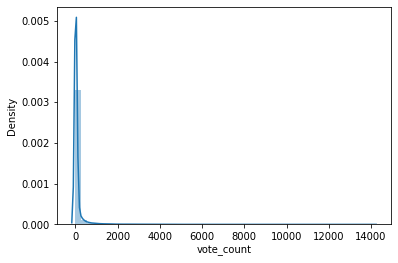

In [7]:
m = vote_counts.quantile(0.95)
sns.distplot(vote_counts)

In [8]:
md['year'] = pd.to_datetime(md.release_date, errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)


In [9]:
qualified = md[(md.vote_count.notnull()) & (md.vote_count > m) & (md.vote_average.notnull())]
qualified['vote_count'] = qualified['vote_count'].astype('int')
qualified['vote_average'] = qualified['vote_average'].astype('float')
qualified.shape

(2268, 25)

In [10]:
# a score method, caring not only the rate, but also vote_cnt and score_mean

def wr(x):
  v = x['vote_count']
  R = x['vote_average']
  return (v/(v+m) * R) + (m/(m+v) * C)
qualified['wr'] = qualified.apply(wr, axis=1)
top100 = qualified.sort_values('wr', ascending=False).head(100)
top100.original_title


314        The Shawshank Redemption
834                   The Godfather
12481               The Dark Knight
2843                     Fight Club
292                    Pulp Fiction
                    ...            
41128                          Lion
18252         The Dark Knight Rises
582      Terminator 2: Judgment Day
33041                     Spotlight
758                   Trainspotting
Name: original_title, Length: 100, dtype: object

by genres:

In [11]:
# a scoring method in some genre
def top(top_num, genres, percentile):
  md_genres = md[[genres in item for item in md['genres']]]
  md_genres['vote_count'] = md_genres['vote_count'].astype('int')
  md_genres['vote_average'] = md_genres['vote_average'].astype('float')
  C_genres = md_genres[md_genres.vote_average.notnull()]['vote_average'].astype('float').mean()
  m_genres = md_genres[md_genres.vote_count.notnull()]['vote_count'].astype('int').quantile(percentile)


  def wr_genres(x):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m_genres) * R) + (m_genres/(m_genres+v) * C_genres)


  qualified_genres = md_genres[(md_genres.vote_count.notnull()) & (md_genres.vote_count > m_genres) & (md_genres.vote_average.notnull())]
  qualified_genres['wr'] = qualified_genres.apply(wr_genres, axis=1)
  top_genres = qualified_genres.sort_values('wr', ascending=False).head(top_num)
  return top_genres

top(10, 'Romance', 0.85)[['original_title', 'wr', 'vote_average']]

,original_title,wr,vote_average
10309,Dilwale Dulhania Le Jayenge,8.701372,9.1
40251,君の名は。,8.281258,8.5
351,Forrest Gump,8.173547,8.2
1132,Nuovo Cinema Paradiso,7.964387,8.2
40882,La La Land,7.860576,7.9
22168,Her,7.855724,7.9
7208,Eternal Sunshine of the Spotless Mind,7.850467,7.9
876,Vertigo,7.840579,8.0
3189,City Lights,7.792600,8.2
15530,Mr. Nobody,7.788307,7.9


# **item based**

In [12]:
links_small = pd.read_csv('/content/drive/MyDrive/movie_recommendation_data/links_small.csv')
links_small.info()
links_small.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9125 entries, 0 to 9124
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9125 non-null   int64  
 1   imdbId   9125 non-null   int64  
 2   tmdbId   9112 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 214.0 KB


movieId     0
imdbId      0
tmdbId     13
dtype: int64

In [13]:
md = md.drop([19730, 29503, 35587]) # 我也不知道他是咋发现的，但是这三个的id不正常

In [14]:
tmdbId = links_small[links_small.tmdbId.notnull()]['tmdbId'].astype('int').values

In [15]:
md['id'] = md['id'].astype('int')
smd = md[md['id'].isin(tmdbId)]
smd.shape

(9099, 25)

In [16]:
smd['tagline'] = smd['tagline'].fillna('')
smd['description'] = smd['overview'] + smd['tagline']
smd['description'] = smd['description'].fillna('')

In [17]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(smd['description'])
tfidf_matrix.shape

(9099, 268124)

**computing similarity based on tfidf vector if 'description' and 'tagline'**

In [18]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim.shape

(9099, 9099)

In [19]:
def itembased_recommand(title, number):
  index = 0
  for i in range(len(smd)):
    if smd.iloc[i]['original_title'] == title:
      index = i
      break
  sim = list(enumerate(cosine_sim[index]))
  sim = sorted(sim, key=lambda x: x[1], reverse=True)
  top_indices = np.array(sim)[1: number+1, 0]
  titles = smd.iloc[top_indices]['original_title']
  return titles

itembased_recommand('The Godfather', 10)
itembased_recommand('The Dark Knight', 10)

18252                      The Dark Knight Rises
150                               Batman Forever
1328                              Batman Returns
20232    Batman: The Dark Knight Returns, Part 2
15511                 Batman: Under the Red Hood
585                                       Batman
18035                           Batman: Year One
3095                Batman: Mask of the Phantasm
3267                                         JFK
19792    Batman: The Dark Knight Returns, Part 1
Name: original_title, dtype: object

According to MetaData

In [22]:
credits = pd.read_csv('/content/drive/MyDrive/movie_recommendation_data/credits.csv')
keywords = pd.read_csv('/content/drive/MyDrive/movie_recommendation_data/keywords.csv')
credits['id'] = credits['id'].astype('int')
keywords['id'] = keywords['id'].astype('int')

(45463, 25)

In [26]:
keywords.head()

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [100]:
smd = md.merge(credits, on='id')
smd = smd.merge(keywords, on='id')
smd.shape

(46628, 28)

In [101]:
smd = smd[smd['id'].isin(tmdbId)]
smd.shape

(9219, 28)

In [102]:
smd.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,year,cast,crew,keywords
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,1995,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,1995,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.85949,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,1995,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...","[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.38752,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,1995,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [103]:
smd['cast'] = smd['cast'].apply(literal_eval)
smd['crew'] = smd['crew'].apply(literal_eval)
smd['keywords'] = smd['keywords'].apply(literal_eval)
smd['cast_size'] = smd['cast'].apply(lambda x: len(x))
smd['crew_size'] = smd['crew'].apply(lambda x: len(x))

In [104]:
smd.keywords

0        [{'id': 931, 'name': 'jealousy'}, {'id': 4290,...
1        [{'id': 10090, 'name': 'board game'}, {'id': 1...
2        [{'id': 1495, 'name': 'fishing'}, {'id': 12392...
3        [{'id': 818, 'name': 'based on novel'}, {'id':...
4        [{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n...
                               ...                        
40952    [{'id': 6054, 'name': 'friendship'}, {'id': 20...
41172                 [{'id': 10540, 'name': 'bollywood'}]
41225                 [{'id': 10540, 'name': 'bollywood'}]
41391    [{'id': 1299, 'name': 'monster'}, {'id': 7671,...
41669    [{'id': 6027, 'name': 'music'}, {'id': 10073, ...
Name: keywords, Length: 9219, dtype: object

In [105]:
def director(crew):
  for i in crew:
    if i['job'] == 'Director':
      return i['name']
  return np.nan

In [106]:
smd['director'] = smd['crew'].apply(director)

In [107]:
smd['cast'] = smd['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
smd['cast'] = smd['cast'].apply(lambda x: x[0:3] if len(x) > 3 else x)

In [108]:
smd['cast'].head(100)

0                    [Tom Hanks, Tim Allen, Don Rickles]
1         [Robin Williams, Jonathan Hyde, Kirsten Dunst]
2             [Walter Matthau, Jack Lemmon, Ann-Margret]
3      [Whitney Houston, Angela Bassett, Loretta Devine]
4             [Steve Martin, Diane Keaton, Martin Short]
                             ...                        
101         [Ray Liotta, Linda Fiorentino, Peter Coyote]
102    [Adam Sandler, Ben Stiller, Christopher McDonald]
103         [Meryl Streep, Clint Eastwood, Annie Corley]
105         [Tim Curry, Kevin Bishop, Jennifer Saunders]
106    [Christy Turlington, Azzedine Alaïa, Giorgio A...
Name: cast, Length: 100, dtype: object

In [109]:
smd['keywords'] = smd['keywords'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [111]:
smd['cast'] = smd['cast'].apply(lambda x: [str.lower(i.replace(' ', '')) for i in x])
smd['director'] = smd['director'].apply(lambda x: str.lower(str(x)))
# someone believes the director is more important; ... hei ren wen hao lian
smd['director'] = smd['director'].apply(lambda x: [x, x, x]) 

In [112]:
stemmer = SnowballStemmer('english')

In [113]:
smd.keywords

0        [jealousy, toy, boy, friendship, friends, riva...
1        [board game, disappearance, based on children'...
2        [fishing, best friend, duringcreditsstinger, o...
3        [based on novel, interracial relationship, sin...
4        [baby, midlife crisis, confidence, aging, daug...
                               ...                        
40952                           [friendship, brick making]
41172                                          [bollywood]
41225                                          [bollywood]
41391    [monster, godzilla, giant monster, destruction...
41669                                 [music, documentary]
Name: keywords, Length: 9219, dtype: object

In [119]:
smd['keywords'] = smd['keywords'].apply(lambda x: [stemmer.stem(i) for i in x])
smd['keywords'] = smd['keywords'].apply(lambda x: [str.lower(i.replace(' ', '')) for i in x])
smd['soup'] = smd['cast'] + smd['director'] + smd['keywords']

In [124]:
smd['soup'] = smd['soup'].apply(lambda x: ' '.join(x))

In [125]:
count = CountVectorizer(analyzer='word', ngram_range=(1, 2), min_df=0, stop_words='english')
count_matrix = count.fit_transform(smd['soup'])
cosine_sim = cosine_similarity(count_matrix, count_matrix)


itembased_recommand('The Godfather', 10)

4470    Tucker: The Man and His Dream
2376            Peggy Sue Got Married
6040               One from the Heart
4602                  The Cotton Club
4012                 Gardens of Stone
754                              Jack
1614                    The Rainmaker
3635                 The Conversation
8911                      Rumble Fish
1934          The Godfather: Part III
Name: original_title, dtype: object

**With** **Rating** : sort the top 100 movies by 'wr' and recommand the first 10 movies


# **collaborative filtering**

In [127]:
rating = pd.read_csv('/content/drive/MyDrive/movie_recommendation_data/ratings_small.csv')
rating.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [128]:
rating.userId.unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [129]:
reader = Reader()
M = Dataset.load_from_df(rating[['userId', 'movieId', 'rating']], reader)

In [133]:
train = M.build_full_trainset()

**BiasSVD**

In [134]:
svd = SVD()
svd.fit(train)

In [136]:
a = svd.predict(193, 302)

In [138]:
a.est

3.7809666416220287

**FunkSVD(NMF)**


In [139]:
from surprise  import NMF
nmf = NMF()
nmf.fit(train)
nmf.predict(193, 302)

Prediction(uid=193, iid=302, r_ui=None, est=3.4485080539798636, details={'was_impossible': False})

**SVDpp**
take super long time to fit the trainging set

In [140]:
from surprise import SVDpp
svdpp = SVDpp()
svdpp.fit(train)
svdpp.predict(193, 302)

Prediction(uid=193, iid=302, r_ui=None, est=4.084731345663317, details={'was_impossible': False})

# **Hybrid Recommender**

mix 'item based' and SVD


In [ ]:
def INT(x):
  try:
    return int(x)
  except:
    return np.nan
    

In [ ]:
id_map = pd.read_csv('links_small.csv')[['movieId', 'tmdbId']]
id_map.movieId = id_map.movieId.apply(INT)
id_map.columns = ['movieId', 'id']
id_map = id_map.merge(smd[['title', 'vote_count', 'vote_average', 'year', 'id']], on='id')

def recommend(UserID, title):
  index = 0
  for i in range(len(id_map)):
    if id_map.iloc[i]['title'] == title:
      index = i
      break
  # based on the previous sim_matrix we have computed
  sim = list(enumerate(cosine_sim[index]))
  sim = sorted(sim, key=lambda x: x[1], reverse=True)
  top_indices = np.array(sim)[1: 101, 0]

  # get the top 100 items that most similar to this movie
  movies = id_map.iloc[top_indices]
  # sorting in this top 100 similar movies using CF
  movies['est'] = movies['movieId'].apply(lambda x: svd.predict(UserID, x))
  return movies.sort_values('est', ascending=False).head(10)